In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Attention
from sklearn.model_selection import TimeSeriesSplit

# configuración de warnings
import warnings
warnings.filterwarnings('ignore')

# Carga de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_test = pd.read_csv('/content/drive/MyDrive/Modulo4_CDD_Student/Redes neuronales/SSNMX_catalogo_20240101_20241231.csv', sep='\t',skiprows=4,skipfooter=7, engine='python')
data_train = pd.read_csv('/content/drive/MyDrive/Modulo4_CDD_Student/Redes neuronales/SSNMX_catalogo_20140101_20231231.csv', sep='\t',skiprows=4,skipfooter=7, engine='python')

In [ ]:
data_train

,"Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,""Referencia de localizacion"",""Fecha UTC"",""Hora UTC"",""Estatus"""
0,"2014-01-01,00:53:44,3.7,19.5842,-104.564,12.9,..."
1,"2014-01-01,01:06:56,4.0,14.2358,-91.7323,63.9,..."
2,"2014-01-01,03:44:36,3.8,17.1255,-99.8737,38.9,..."
3,"2014-01-01,09:12:20,3.8,15.7142,-98.5872,11.7,..."
4,"2014-01-01,10:07:39,4.0,15.9363,-98.6932,9.7,""..."
...,...
230657,"2023-12-31,22:20:31,3.5,15.7617,-98.132,11.9,""..."
230658,"2023-12-31,22:56:54,3.1,31.723,-116.337,22.9,""..."
230659,"2023-12-31,23:02:22,3.8,15.9787,-97.5335,19.9,..."
230660,"2023-12-31,23:17:32,3.7,20.0188,-105.413,11.3,..."


**Preprocesamiento de datos de entrenamiento**

In [ ]:
data_train_expanded = data_train['Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,"Referencia de localizacion","Fecha UTC","Hora UTC","Estatus"'].str.split(',', expand=True)


column_names = ["Fecha", "Hora", "Magnitud", "Latitud", "Longitud", "Profundidad",
                "Referencia de localizacion", "Fecha UTC", "Hora UTC", "Estatus"]

# Si hay más columnas de las esperadas, se agregan nombres genéricos
if data_train_expanded.shape[1] > len(column_names):
    for i in range(len(column_names), data_train_expanded.shape[1]):
        column_names.append(f"Columna_{i}")

data_train_expanded.columns = column_names
data_train_expanded.columns =  ["Fecha", "Hora", "Magnitud", "Latitud", "Longitud", "Profundidad",
                "Referencia de localizacion","Estado", "Fecha UTC", "Hora UTC", "Estatus"]

data_train_expanded.drop(columns=[
    "Referencia de localizacion",
    "Fecha UTC",
    "Hora UTC",
    "Estatus"
], inplace=True)
data_train_expanded['Estado'] = data_train_expanded['Estado'].str.rstrip("'").str.rstrip('"')
data_train_expanded['Estado'] = data_train_expanded['Estado'].str.strip()
data_train = data_train_expanded
data_train.head()

,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Estado
0,2014-01-01,00:53:44,3.7,19.5842,-104.564,12.9,JAL
1,2014-01-01,01:06:56,4.0,14.2358,-91.7323,63.9,CHIS
2,2014-01-01,03:44:36,3.8,17.1255,-99.8737,38.9,GRO
3,2014-01-01,09:12:20,3.8,15.7142,-98.5872,11.7,OAX
4,2014-01-01,10:07:39,4.0,15.9363,-98.6932,9.7,OAX


In [ ]:
data_train["Estado"].unique()

array(['JAL', 'CHIS', 'GRO', 'OAX', 'VER', 'MICH', 'NL', 'BC', 'TAB',
       'TAMS', 'BCS', 'COL', 'PUE', 'QR', 'SON', 'CHIH', 'SIN', 'COAH',
       'MEX', 'NAY', 'ZAC', 'SLP', 'HGO', 'CDMX', 'AGS', 'DGO', 'GTO',
       'MOR', 'CAMP', 'TLAX', 'YUC', 'QRO', 'N'], dtype=object)

In [ ]:
data_train["Estado"] = data_train["Estado"].replace('N', 'NL')

In [ ]:
le = LabelEncoder()
data_train['Estado'] = le.fit_transform(data_train['Estado'])

In [ ]:
data_train["Estado"].unique()

array([13,  6, 10, 19, 29, 15, 18,  1, 26, 27,  2,  8, 20, 21, 25,  5, 23,
        7, 14, 17, 31, 24, 12,  4,  0,  9, 11, 16,  3, 28, 30, 22])

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230662 entries, 0 to 230661
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Fecha        230662 non-null  object
 1   Hora         230662 non-null  object
 2   Magnitud     230662 non-null  object
 3   Latitud      230662 non-null  object
 4   Longitud     230662 non-null  object
 5   Profundidad  230662 non-null  object
 6   Estado       230662 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 12.3+ MB


In [ ]:
columnas_numericas = ['Magnitud', 'Latitud', 'Longitud', 'Profundidad']

for columna in columnas_numericas:
    data_train[columna] = pd.to_numeric(data_train[columna], errors='coerce')

data_train['Fecha'] = pd.to_datetime(data_train['Fecha'], format='%Y-%m-%d')
data_train['Hora'] = pd.to_datetime(data_train['Hora'], format='%H:%M:%S').dt.time

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230662 entries, 0 to 230661
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Fecha        230662 non-null  datetime64[ns]
 1   Hora         230662 non-null  object        
 2   Magnitud     230660 non-null  float64       
 3   Latitud      230662 non-null  float64       
 4   Longitud     230662 non-null  float64       
 5   Profundidad  230662 non-null  float64       
 6   Estado       230662 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 12.3+ MB


In [ ]:
data_train.isna().sum()

,0
Fecha,0
Hora,0
Magnitud,2
Latitud,0
Longitud,0
Profundidad,0
Estado,0


In [ ]:
data_train_clean = data_train.dropna(subset=['Magnitud'])
data_train =data_train_clean

In [ ]:
data_train.isna().sum()

,0
Fecha,0
Hora,0
Magnitud,0
Latitud,0
Longitud,0
Profundidad,0
Estado,0


In [ ]:
data_train

,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Estado
0,2014-01-01,00:53:44,3.7,19.5842,-104.5640,12.9,13
1,2014-01-01,01:06:56,4.0,14.2358,-91.7323,63.9,6
2,2014-01-01,03:44:36,3.8,17.1255,-99.8737,38.9,10
3,2014-01-01,09:12:20,3.8,15.7142,-98.5872,11.7,19
4,2014-01-01,10:07:39,4.0,15.9363,-98.6932,9.7,19
...,...,...,...,...,...,...,...
230657,2023-12-31,22:20:31,3.5,15.7617,-98.1320,11.9,19
230658,2023-12-31,22:56:54,3.1,31.7230,-116.3370,22.9,1
230659,2023-12-31,23:02:22,3.8,15.9787,-97.5335,19.9,19
230660,2023-12-31,23:17:32,3.7,20.0188,-105.4130,11.3,13


In [ ]:
data_train['Fecha_Hora'] = pd.to_datetime(
    data_train['Fecha'].astype(str) + ' ' + data_train['Hora'].astype(str),
    format='%Y-%m-%d %H:%M:%S'
)
data_train.drop(columns=['Fecha', 'Hora'], inplace=True)
data_train

,Magnitud,Latitud,Longitud,Profundidad,Estado,Fecha_Hora
0,3.7,19.5842,-104.5640,12.9,13,2014-01-01 00:53:44
1,4.0,14.2358,-91.7323,63.9,6,2014-01-01 01:06:56
2,3.8,17.1255,-99.8737,38.9,10,2014-01-01 03:44:36
3,3.8,15.7142,-98.5872,11.7,19,2014-01-01 09:12:20
4,4.0,15.9363,-98.6932,9.7,19,2014-01-01 10:07:39
...,...,...,...,...,...,...
230657,3.5,15.7617,-98.1320,11.9,19,2023-12-31 22:20:31
230658,3.1,31.7230,-116.3370,22.9,1,2023-12-31 22:56:54
230659,3.8,15.9787,-97.5335,19.9,19,2023-12-31 23:02:22
230660,3.7,20.0188,-105.4130,11.3,13,2023-12-31 23:17:32


In [ ]:
data_train['Anio'] = data_train['Fecha_Hora'].dt.year
data_train['Mes'] = data_train['Fecha_Hora'].dt.month
data_train['Dia'] = data_train['Fecha_Hora'].dt.day
data_train['Hora'] = data_train['Fecha_Hora'].dt.hour
data_train['Minuto'] = data_train['Fecha_Hora'].dt.minute
data_train['Segundo'] = data_train['Fecha_Hora'].dt.second
data_train.drop(columns=['Fecha_Hora'], inplace=True)
data_train

,Magnitud,Latitud,Longitud,Profundidad,Estado,Anio,Mes,Dia,Hora,Minuto,Segundo
0,3.7,19.5842,-104.5640,12.9,13,2014,1,1,0,53,44
1,4.0,14.2358,-91.7323,63.9,6,2014,1,1,1,6,56
2,3.8,17.1255,-99.8737,38.9,10,2014,1,1,3,44,36
3,3.8,15.7142,-98.5872,11.7,19,2014,1,1,9,12,20
4,4.0,15.9363,-98.6932,9.7,19,2014,1,1,10,7,39
...,...,...,...,...,...,...,...,...,...,...,...
230657,3.5,15.7617,-98.1320,11.9,19,2023,12,31,22,20,31
230658,3.1,31.7230,-116.3370,22.9,1,2023,12,31,22,56,54
230659,3.8,15.9787,-97.5335,19.9,19,2023,12,31,23,2,22
230660,3.7,20.0188,-105.4130,11.3,13,2023,12,31,23,17,32


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230660 entries, 0 to 230661
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Magnitud     230660 non-null  float64
 1   Latitud      230660 non-null  float64
 2   Longitud     230660 non-null  float64
 3   Profundidad  230660 non-null  float64
 4   Estado       230660 non-null  int64  
 5   Anio         230660 non-null  int32  
 6   Mes          230660 non-null  int32  
 7   Dia          230660 non-null  int32  
 8   Hora         230660 non-null  int32  
 9   Minuto       230660 non-null  int32  
 10  Segundo      230660 non-null  int32  
dtypes: float64(4), int32(6), int64(1)
memory usage: 15.8 MB


**Preprocesamiento de datos de prueba**

In [ ]:
data_test_expanded = data_test['Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,"Referencia de localizacion","Fecha UTC","Hora UTC","Estatus"'].str.split(',', expand=True)


column_names = ["Fecha", "Hora", "Magnitud", "Latitud", "Longitud", "Profundidad",
                "Referencia de localizacion", "Fecha UTC", "Hora UTC", "Estatus"]

# Si hay más columnas de las esperadas, se agregan nombres genéricos
if data_test_expanded.shape[1] > len(column_names):
    for i in range(len(column_names), data_test_expanded.shape[1]):
        column_names.append(f"Columna_{i}")

data_test_expanded.columns = column_names
data_test_expanded.columns =  ["Fecha", "Hora", "Magnitud", "Latitud", "Longitud", "Profundidad",
                "Referencia de localizacion","Estado", "Fecha UTC", "Hora UTC", "Estatus"]

data_test_expanded.drop(columns=[
    "Referencia de localizacion",
    "Fecha UTC",
    "Hora UTC",
    "Estatus"
], inplace=True)
data_test_expanded['Estado'] = data_test_expanded['Estado'].str.rstrip("'").str.rstrip('"')
data_test_expanded['Estado'] = data_test_expanded['Estado'].str.strip()
data_test= data_test_expanded
data_test.head()

,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Estado
0,2024-01-01,00:15:51,3.2,18.7483,-104.602,16.5,COL
1,2024-01-01,00:30:39,4.3,15.5482,-95.8245,16.1,OAX
2,2024-01-01,00:53:59,3.1,19.5943,-102.495,5.3,MICH
3,2024-01-01,01:09:24,3.2,18.4185,-100.423,55.4,GRO
4,2024-01-01,01:16:57,3.1,19.7267,-104.657,54.0,JAL


In [ ]:
data_test["Estado"].unique()

array(['COL', 'OAX', 'MICH', 'GRO', 'JAL', 'CHIS', 'BC', 'VER', 'ZAC',
       'BCS', 'PUE', 'HGO', 'TLAX', 'SON', 'CHIH', 'TAB', 'NAY', 'CDMX',
       'MOR', 'GTO', 'SIN', 'TAMS', 'MEX', 'NL', 'COAH', 'QRO', 'SLP'],
      dtype=object)

In [ ]:
data_test['Estado'] = le.transform(data_test['Estado'])

In [ ]:
data_test["Estado"].unique()

array([ 8, 19, 15, 10, 13,  6,  1, 29, 31,  2, 20, 12, 28, 25,  5, 26, 17,
        4, 16, 11, 23, 27, 14, 18,  7, 22, 24])

In [ ]:
columnas_numericas = ['Magnitud', 'Latitud', 'Longitud', 'Profundidad']

for columna in columnas_numericas:
    data_test[columna] = pd.to_numeric(data_test[columna], errors='coerce')

data_test['Fecha'] = pd.to_datetime(data_test['Fecha'], format='%Y-%m-%d')
data_test['Hora'] = pd.to_datetime(data_test['Hora'], format='%H:%M:%S').dt.time

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230660 entries, 0 to 230661
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Magnitud     230660 non-null  float64
 1   Latitud      230660 non-null  float64
 2   Longitud     230660 non-null  float64
 3   Profundidad  230660 non-null  float64
 4   Estado       230660 non-null  int64  
 5   Anio         230660 non-null  int32  
 6   Mes          230660 non-null  int32  
 7   Dia          230660 non-null  int32  
 8   Hora         230660 non-null  int32  
 9   Minuto       230660 non-null  int32  
 10  Segundo      230660 non-null  int32  
dtypes: float64(4), int32(6), int64(1)
memory usage: 15.8 MB


In [ ]:
data_train.isna().sum()

,0
Magnitud,0
Latitud,0
Longitud,0
Profundidad,0
Estado,0
Anio,0
Mes,0
Dia,0
Hora,0
Minuto,0


In [ ]:
data_test['Fecha_Hora'] = pd.to_datetime(
    data_test['Fecha'].astype(str) + ' ' + data_test['Hora'].astype(str),
    format='%Y-%m-%d %H:%M:%S'
)
data_test.drop(columns=['Fecha', 'Hora'], inplace=True)
data_test

,Magnitud,Latitud,Longitud,Profundidad,Estado,Fecha_Hora
0,3.2,18.7483,-104.6020,16.5,8,2024-01-01 00:15:51
1,4.3,15.5482,-95.8245,16.1,19,2024-01-01 00:30:39
2,3.1,19.5943,-102.4950,5.3,15,2024-01-01 00:53:59
3,3.2,18.4185,-100.4230,55.4,10,2024-01-01 01:09:24
4,3.1,19.7267,-104.6570,54.0,13,2024-01-01 01:16:57
...,...,...,...,...,...,...
33329,3.9,16.1610,-92.9310,186.4,6,2024-12-31 22:58:38
33330,3.6,17.2400,-101.0400,30.2,10,2024-12-31 23:05:25
33331,4.2,25.3000,-98.6720,5.0,27,2024-12-31 23:15:49
33332,3.3,17.2730,-99.8200,30.5,10,2024-12-31 23:32:11


In [ ]:
data_test['Anio'] = data_test['Fecha_Hora'].dt.year
data_test['Mes'] = data_test['Fecha_Hora'].dt.month
data_test['Dia'] = data_test['Fecha_Hora'].dt.day
data_test['Hora'] = data_test['Fecha_Hora'].dt.hour
data_test['Minuto'] = data_test['Fecha_Hora'].dt.minute
data_test['Segundo'] = data_test['Fecha_Hora'].dt.second
data_test.drop(columns=['Fecha_Hora'], inplace=True)
data_test

,Magnitud,Latitud,Longitud,Profundidad,Estado,Anio,Mes,Dia,Hora,Minuto,Segundo
0,3.2,18.7483,-104.6020,16.5,8,2024,1,1,0,15,51
1,4.3,15.5482,-95.8245,16.1,19,2024,1,1,0,30,39
2,3.1,19.5943,-102.4950,5.3,15,2024,1,1,0,53,59
3,3.2,18.4185,-100.4230,55.4,10,2024,1,1,1,9,24
4,3.1,19.7267,-104.6570,54.0,13,2024,1,1,1,16,57
...,...,...,...,...,...,...,...,...,...,...,...
33329,3.9,16.1610,-92.9310,186.4,6,2024,12,31,22,58,38
33330,3.6,17.2400,-101.0400,30.2,10,2024,12,31,23,5,25
33331,4.2,25.3000,-98.6720,5.0,27,2024,12,31,23,15,49
33332,3.3,17.2730,-99.8200,30.5,10,2024,12,31,23,32,11


In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33334 entries, 0 to 33333
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Magnitud     33334 non-null  float64
 1   Latitud      33334 non-null  float64
 2   Longitud     33334 non-null  float64
 3   Profundidad  33334 non-null  float64
 4   Estado       33334 non-null  int64  
 5   Anio         33334 non-null  int32  
 6   Mes          33334 non-null  int32  
 7   Dia          33334 non-null  int32  
 8   Hora         33334 non-null  int32  
 9   Minuto       33334 non-null  int32  
 10  Segundo      33334 non-null  int32  
dtypes: float64(4), int32(6), int64(1)
memory usage: 2.0 MB


# Escalamiento de Datos

In [ ]:
features = ['Latitud', 'Longitud', 'Profundidad', 'Estado', 'Anio', 'Mes', 'Dia', 'Hora', 'Minuto' ]
target = ['Magnitud']

scaler = MinMaxScaler()
data_train[features] = scaler.fit_transform(data_train[features])
data_train[target] = scaler.fit_transform(data_train[target])

In [ ]:
data_test[features] = scaler.fit_transform(data_test[features])
data_test[target] = scaler.fit_transform(data_test[target])

In [ ]:
data_train.head()

,Magnitud,Latitud,Longitud,Profundidad,Estado,Anio,Mes,Dia,Hora,Minuto,Segundo
0,0.430380,0.334751,0.484464,0.046137,0.419355,0.0,0.0,0.0,0.000000,0.898305,44
1,0.468354,0.142510,0.872243,0.228541,0.193548,0.0,0.0,0.0,0.043478,0.101695,56
2,0.443038,0.246376,0.626207,0.139127,0.322581,0.0,0.0,0.0,0.130435,0.745763,36
3,0.443038,0.195649,0.665085,0.041845,0.612903,0.0,0.0,0.0,0.391304,0.203390,20
4,0.468354,0.203632,0.661882,0.034692,0.612903,0.0,0.0,0.0,0.434783,0.118644,39


In [ ]:
features = ['Latitud', 'Longitud', 'Profundidad', 'Estado', 'Anio', 'Mes', 'Dia', 'Hora', 'Minuto', 'Magnitud']
data_train_array = data_train[features].values
data_train_array[0:5]

array([[0.33475071, 0.48446368, 0.04613734, 0.41935484, 0.        ,
        0.        , 0.        , 0.        , 0.89830508, 0.43037975],
       [0.14250952, 0.87224314, 0.22854077, 0.19354839, 0.        ,
        0.        , 0.        , 0.04347826, 0.10169492, 0.46835443],
       [0.24637598, 0.62620655, 0.13912732, 0.32258065, 0.        ,
        0.        , 0.        , 0.13043478, 0.74576271, 0.44303797],
       [0.19564866, 0.66508513, 0.04184549, 0.61290323, 0.        ,
        0.        , 0.        , 0.39130435, 0.20338983, 0.44303797],
       [0.20363175, 0.66188177, 0.03469242, 0.61290323, 0.        ,
        0.        , 0.        , 0.43478261, 0.11864407, 0.46835443]])

In [ ]:
data_test.head()

,Magnitud,Latitud,Longitud,Profundidad,Estado,Anio,Mes,Dia,Hora,Minuto,Segundo
0,0.456140,0.299915,0.500493,0.066065,0.233333,0.0,0.0,0.0,0.000000,0.254237,51
1,0.649123,0.139106,0.820711,0.064423,0.600000,0.0,0.0,0.0,0.000000,0.508475,39
2,0.438596,0.342427,0.577359,0.020107,0.466667,0.0,0.0,0.0,0.000000,0.898305,59
3,0.456140,0.283342,0.652950,0.225687,0.300000,0.0,0.0,0.0,0.043478,0.152542,24
4,0.438596,0.349080,0.498486,0.219943,0.400000,0.0,0.0,0.0,0.043478,0.271186,57


In [ ]:
data_test_array = data_test[features].values
data_test_array

array([[0.29991457, 0.5004925 , 0.06606483, ..., 0.        , 0.25423729,
        0.45614035],
       [0.13910553, 0.82071066, 0.06442347, ..., 0.        , 0.50847458,
        0.64912281],
       [0.34242714, 0.57735945, 0.02010669, ..., 0.        , 0.89830508,
        0.43859649],
       ...,
       [0.62914573, 0.71682901, 0.01887567, ..., 1.        , 0.25423729,
        0.63157895],
       [0.22577889, 0.67494801, 0.12351252, ..., 1.        , 0.54237288,
        0.47368421],
       [0.29753769, 0.42096239, 0.0393927 , ..., 1.        , 0.76271186,
        0.57894737]])

# Secuencias Temporales

In [ ]:
def create_dataset(dataset, look_back=100): #variar elm 60
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, -1])
    return np.array(X), np.array(Y)

In [ ]:
X_train, y_train = create_dataset(data_train_array, 85)

In [ ]:
X_test, y_test = create_dataset(data_test_array, 85)

# Modelo LSTM y entrenamiento

In [ ]:
look_back = 85
n_features = X_train.shape[2]

model = Sequential([
    # Primera capa LSTM bidireccional
    Bidirectional(LSTM(128,
                      activation='tanh',
                      return_sequences=True,
                      input_shape=(look_back, n_features))),
    Dropout(0.3),

    # Segunda capa LSTM bidireccional
    Bidirectional(LSTM(128,
                      activation='tanh',
                      return_sequences=True)),
    Dropout(0.3),

    # Tercera capa LSTM
    LSTM(64,
         activation='tanh',
         return_sequences=False),
    Dropout(0.2),

    # Capa de salida
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error')

tscv = TimeSeriesSplit(n_splits=5)
for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    if len(X_train_fold) > 0 and len(X_val_fold) > 0:
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=3,
            batch_size=32,
            verbose=1
        )

Epoch 1/3
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 2/3
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 3/3
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 1/3
2402/2402 ━━━━━━━━━━━━━━━━━━━━ 77s 32ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 2/3
2402/2402 ━━━━━━━━━━━━━━━━━━━━ 69s 27ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 3/3
2402/2402 ━━━━━━━━━━━━━━━━━━━━ 62s 26ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 1/3
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 101s 28ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 2/3
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 142s 28ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 3/3
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 91s 25ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 1/3
4804/4804 ━━━━━━━━━━━━━━━━━━━━ 119s 25ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 2/3
4804/4804 ━━━━━━━━━━━━━━━━━━━━ 139s 24ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 3/3
4804/48

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 85, 256)        │       142,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 85, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 85, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 85, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,856,453 (7.08 MB)

 Trainable params: 618,817 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,237,636 (4.72 MB)

# Predicción

1040/1040 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


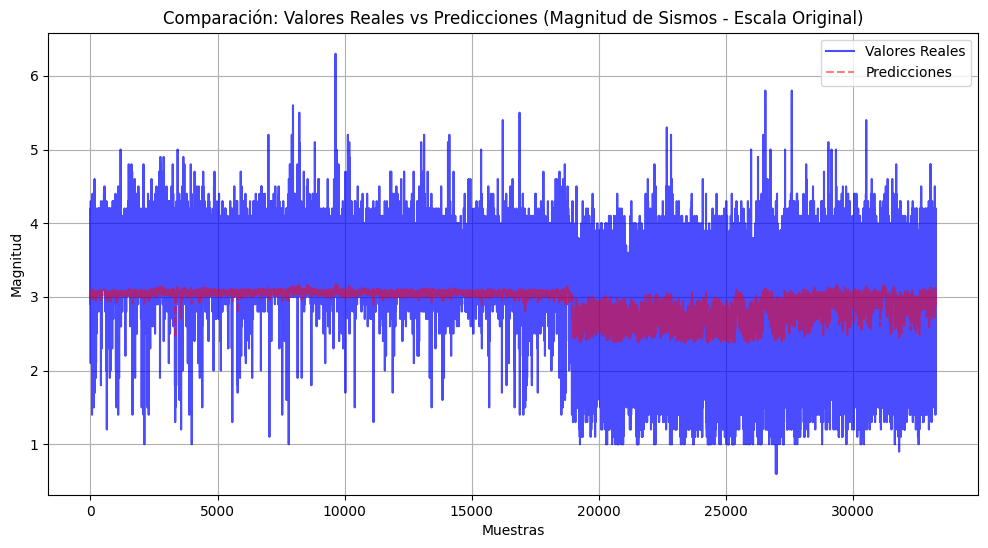

In [ ]:
y_pred = model.predict(X_test)
y_real_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_orig = scaler.inverse_transform(y_pred)


plt.figure(figsize=(12, 6))
plt.plot(y_real_orig, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(y_pred_orig, label='Predicciones', color='red', alpha=0.5, linestyle='--')
plt.title('Comparación: Valores Reales vs Predicciones (Magnitud de Sismos - Escala Original)')
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.legend()
plt.grid(True)
plt.show()


# Evaluación de modelo

In [ ]:

print("\nEvaluación en datos de prueba:")
test_loss = model.evaluate(X_test, y_test, verbose=0)  # Get the single loss value
print(f"- Loss (MSE): {test_loss:.4f}") # Print the loss value


Evaluación en datos de prueba:
- Loss (MSE): 0.0162


In [ ]:
def calcular_metricas(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

mae, mse, rmse = calcular_metricas(y_test, model.predict(X_test))
print("\nMétricas completas:")
print(f"- MAE: {mae:.4f}")
print(f"- MSE: {mse:.4f}")
print(f"- RMSE: {rmse:.4f}")
print(f"- R²: {r2_score(y_test, model.predict(X_test)):.4f}")

1040/1040 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step

Métricas completas:
- MAE: 0.1073
- MSE: 0.0162
- RMSE: 0.1273
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
- R²: 0.1585
